In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
# plt.style.use('ggplot')
%matplotlib inline

In [2]:
import os
import logging
from functools import partial

from jax import random
from torchvision import transforms
import wandb
from flax.training.checkpoints import save_checkpoint, restore_checkpoint

from src.models import make_Hard_OvR_Ens_loss as make_prod_loss
from src.models import make_Hard_OvR_Ens_MNIST_plots as make_plots
from src.models import make_Cls_Ens_loss as make_ens_loss
from src.data import get_image_dataset, NumpyLoader
from src.utils.training import setup_training, train_loop
from experiments.configs.mnist_hard_ovr_classification import get_config

In [3]:
os.environ['WANDB_NOTEBOOK_NAME'] = 'cls_comparison_figures.ipynb'
# ^ W&B doesn't know how to handle VS Code notebooks.

wandb.login()

wandb: Currently logged in as: jamesallingham (invariance-learners). Use `wandb login --relogin` to force relogin


True

In [4]:
config = get_config()

In [5]:
train_dataset, _, val_dataset = get_image_dataset(
    dataset_name=config.dataset_name,
    val_percent=config.val_percent,
    flatten_img=True,
    train_augmentations=[
        # transforms.RandomCrop(28, padding=2),
        # transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),
        # transforms.RandomHorizontalFlip(),
        # transforms.
    ]
)
ens_train_loader = NumpyLoader(train_dataset, config.batch_size, num_workers=8)
ens_val_loader = NumpyLoader(val_dataset, config.batch_size, num_workers=8)

train_dataset, test_dataset, val_dataset = get_image_dataset(
    dataset_name=config.dataset_name,
    val_percent=config.val_percent,
    flatten_img=True,
    train_augmentations=[
        # transforms.RandomCrop(28, padding=2),
        # transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), shear=5),
        # transforms.RandomHorizontalFlip(),
        # transforms.
    ]
)
train_loader = NumpyLoader(train_dataset, config.batch_size, num_workers=8)
val_loader = NumpyLoader(val_dataset, config.batch_size, num_workers=8)
test_loader = NumpyLoader(test_dataset, config.batch_size, num_workers=8)

In [6]:
ens_config = config.copy_and_resolve_references()
ens_config.model_name = 'Cls_Ens'
del ens_config.β_schedule

In [7]:
best_ens_states = []
best_prod_states = []

RECOMPUTE_PROD = False
RECOMPUTE_ENS = False
RECOMPUTE_PROD_STD = True
PRETRAIN_PROD = False

for i in range(0, 3):
    rng = random.PRNGKey(i)
    setup_rng, rng = random.split(rng)
    init_x = train_dataset[0][0]
    init_y = train_dataset[0][1]

    ens_model, state = setup_training(ens_config, setup_rng, init_x, init_y)

    if RECOMPUTE_ENS:
        _, ens_state = train_loop(
            ens_model, state, ens_config, rng, make_ens_loss, make_ens_loss, ens_train_loader, ens_val_loader,
            # test_loader,
            wandb_kwargs={
                'mode': 'offline',
                # 'notes': 'Data augmentation',
                # 'tags': ['MNIST testing'],
            },
            # plot_fn=make_plots,
            # plot_freq=1,
        )

        save_checkpoint(f'dynNN_redux/ens_model_{i}', ens_state, 1, overwrite=True)

    rng = random.PRNGKey(i)
    setup_rng, rng = random.split(rng)

    prod_model, state = setup_training(config, setup_rng, init_x, init_y)

    if RECOMPUTE_PROD:
        if PRETRAIN_PROD:
            state.replace(params=ens_state.params)
            # TODO: Also replace BN (model) state?

        _, prod_state = train_loop(
            prod_model, state, config, rng, partial(make_prod_loss, per_member_loss=0.5), partial(make_prod_loss, per_member_loss=0.5), train_loader, val_loader,
            # test_loader,
            wandb_kwargs={
                'mode': 'offline',
                # 'notes': 'pre-trained',
                # 'tags': ['MNIST testing', 'pre-trained'],
            },
            # plot_fn=make_plots,
            # plot_freq=1,
        )

        save_checkpoint(f'dynNN_redux/prod_model_{i}', prod_state, 1, overwrite=True)

    stdprod_model, state = setup_training(config, setup_rng, init_x, init_y)

    if RECOMPUTE_PROD_STD:
        rng = random.PRNGKey(i)
        setup_rng, rng = random.split(rng)

        _, stdprod_state = train_loop(
            stdprod_model, state, config, rng, partial(make_prod_loss, per_member_loss=0.00), partial(make_prod_loss, per_member_loss=0.00), train_loader, val_loader,
            # test_loader,
            wandb_kwargs={
                'mode': 'offline',
                # 'notes': 'pre-trained',
                # 'tags': ['MNIST testing', 'pre-trained'],
            },
            # plot_fn=make_plots,
            # plot_freq=1,
        )

        save_checkpoint(f'dynNN_redux/stdprod_model_{i}', stdprod_state, 1, overwrite=True)

+---------------------------------------------+------------+---------+-----------+--------+
| Name                                        | Shape      | Size    | Mean      | Std    |
+---------------------------------------------+------------+---------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/var  | (200,)     | 200     | 1.0      

  0%|          | 0/50 [00:00<?, ?it/s]

epoch:   1 - train loss: 0.45672, val loss: 0.19283, train err: 0.1698, val err: 0.0785, β: 2.1141, lr: 0.00360
epoch:   2 - train loss: 0.16234, val loss: 0.14175, train err: 0.0780, val err: 0.0653, β: 2.1391, lr: 0.00420
epoch:   3 - train loss: 0.11401, val loss: 0.11814, train err: 0.0612, val err: 0.0575, β: 2.1695, lr: 0.00480
epoch:   4 - train loss: 0.08570, val loss: 0.10527, train err: 0.0520, val err: 0.0543, β: 2.2065, lr: 0.00540
epoch:   5 - train loss: 0.06525, val loss: 0.09613, train err: 0.0435, val err: 0.0477, β: 2.2513, lr: 0.00600
epoch:   6 - train loss: 0.05259, val loss: 0.09002, train err: 0.0390, val err: 0.0453, β: 2.3058, lr: 0.00660
epoch:   7 - train loss: 0.04190, val loss: 0.08654, train err: 0.0336, val err: 0.0438, β: 2.3717, lr: 0.00720
epoch:   8 - train loss: 0.03235, val loss: 0.08375, train err: 0.0313, val err: 0.0413, β: 2.4513, lr: 0.00780
epoch:   9 - train loss: 0.02606, val loss: 0.08394, train err: 0.0281, val err: 0.0420, β: 2.5473, lr: 

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
learning_rate,▄▄▅▅▆▇▇██████▇▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
train/err,█▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/err,█▆▅▅▄▄▃▄▃▃▃▃▃▃▃▂▂▂▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val/loss,█▅▃▂▁▁▁▁▁▁▁▁▂▂▂▂▃▃▅▄▄▄▅▄▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄
β,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▆▆▆▇▇▇▇▇██████████
best_epoch,46
best_val_err,0.02133
epoch,50
learning_rate,0.0003


+---------------------------------------------+------------+---------+-----------+--------+
| Name                                        | Shape      | Size    | Mean      | Std    |
+---------------------------------------------+------------+---------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/var  | (200,)     | 200     | 1.0      

  0%|          | 0/50 [00:00<?, ?it/s]

epoch:   1 - train loss: 0.44720, val loss: 0.19565, train err: 0.1721, val err: 0.0830, β: 2.1141, lr: 0.00360
epoch:   2 - train loss: 0.16036, val loss: 0.14665, train err: 0.0766, val err: 0.0650, β: 2.1391, lr: 0.00420
epoch:   3 - train loss: 0.11380, val loss: 0.11943, train err: 0.0605, val err: 0.0580, β: 2.1695, lr: 0.00480
epoch:   4 - train loss: 0.08714, val loss: 0.10767, train err: 0.0542, val err: 0.0520, β: 2.2065, lr: 0.00540
epoch:   5 - train loss: 0.06883, val loss: 0.09842, train err: 0.0468, val err: 0.0482, β: 2.2513, lr: 0.00600
epoch:   6 - train loss: 0.05228, val loss: 0.09071, train err: 0.0402, val err: 0.0450, β: 2.3058, lr: 0.00660
epoch:   7 - train loss: 0.04074, val loss: 0.08502, train err: 0.0351, val err: 0.0460, β: 2.3717, lr: 0.00720
epoch:   8 - train loss: 0.03232, val loss: 0.08370, train err: 0.0318, val err: 0.0422, β: 2.4513, lr: 0.00780
epoch:   9 - train loss: 0.02568, val loss: 0.08241, train err: 0.0291, val err: 0.0417, β: 2.5473, lr: 

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
learning_rate,▄▄▅▅▆▇▇██████▇▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
train/err,█▄▃▃▃▂▂▂▂▂▂▂▂▂▁▁▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/err,█▆▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▃▃▃▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val/loss,█▅▄▃▂▁▁▁▁▁▁▁▂▂▂▂▃▃▄▅▄▃▄▃▄▃▃▃▃▄▃▃▃▃▃▃▃▃▃▃
β,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▆▆▆▇▇▇▇▇██████████
best_epoch,50
best_val_err,0.02133
epoch,50
learning_rate,0.0003


+---------------------------------------------+------------+---------+-----------+--------+
| Name                                        | Shape      | Size    | Mean      | Std    |
+---------------------------------------------+------------+---------+-----------+--------+
| batch_stats/nets_0/layer_0/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_0/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_1/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_2/BatchNorm_0/var  | (200,)     | 200     | 1.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/mean | (200,)     | 200     | 0.0       | 0.0    |
| batch_stats/nets_0/layer_3/BatchNorm_0/var  | (200,)     | 200     | 1.0      

  0%|          | 0/50 [00:00<?, ?it/s]

epoch:   1 - train loss: 0.43643, val loss: 0.20053, train err: 0.1648, val err: 0.0748, β: 2.1141, lr: 0.00360
epoch:   2 - train loss: 0.16299, val loss: 0.14789, train err: 0.0730, val err: 0.0593, β: 2.1391, lr: 0.00420
epoch:   3 - train loss: 0.11577, val loss: 0.12133, train err: 0.0574, val err: 0.0508, β: 2.1695, lr: 0.00480
epoch:   4 - train loss: 0.08596, val loss: 0.10563, train err: 0.0460, val err: 0.0482, β: 2.2065, lr: 0.00540
epoch:   5 - train loss: 0.06681, val loss: 0.09624, train err: 0.0393, val err: 0.0418, β: 2.2513, lr: 0.00600
epoch:   6 - train loss: 0.05186, val loss: 0.09017, train err: 0.0342, val err: 0.0422, β: 2.3058, lr: 0.00660
epoch:   7 - train loss: 0.04091, val loss: 0.08863, train err: 0.0314, val err: 0.0402, β: 2.3717, lr: 0.00720
epoch:   8 - train loss: 0.03338, val loss: 0.08609, train err: 0.0299, val err: 0.0390, β: 2.4513, lr: 0.00780
epoch:   9 - train loss: 0.02782, val loss: 0.08236, train err: 0.0255, val err: 0.0373, β: 2.5473, lr: 

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
learning_rate,▄▄▅▅▆▇▇██████▇▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁
train/err,█▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val/err,█▆▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val/loss,█▅▃▃▂▂▁▁▁▁▁▁▂▂▂▃▃▃▄▄▄▄▄▅▄▄▄▄▄▄▄▄▃▃▃▃▄▄▄▄
β,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▅▅▆▆▆▇▇▇▇▇██████████
best_epoch,38
best_val_err,0.02467
epoch,50
learning_rate,0.0003


## Paper plots

In [8]:
from  functools import partial
from itertools import combinations

import matplotlib
import pandas as pd
import jax
import jax.numpy as jnp
import flax.linen as nn
import distrax
from chex import assert_rank, assert_shape, assert_equal_shape

In [9]:
restored_prod_models = [restore_checkpoint(f'dynNN_redux/prod_model_{i}', 1) for i in range(3)] # 3
restored_ens_models = [restore_checkpoint(f'dynNN_redux/ens_model_{i}', 1) for i in range(3)] # 3
restored_stdprod_models = [restore_checkpoint(f'dynNN_redux/stdprod_model_{i}', 1) for i in range(3)] # 3

In [10]:
text_width = 6.75133 # in  --> Confirmed with template explanation
line_width = 3.25063
dpi = 400

fs_m1 = 7  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9 #  figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family':'serif', 'serif': ['Palatino']})
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

/tmp/ipykernel_4145527/821981954.py:20: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


In [11]:
X_test, y_test = list(zip(*test_loader.dataset))

In [12]:
def categorical_probs(logits):
    assert_rank(logits, 2)
    assert_shape([logits], (None, 10))
    probs = nn.softmax(logits.mean(axis=0))
    assert_shape([probs], (10,))
    return probs

def categorical_entropy(logits):
    probs = categorical_probs(logits)
    cat = distrax.Categorical(probs=probs)
    return cat.entropy()

def categorical_nll(logits, y):
    probs = categorical_probs(logits).clip(min=1e-36)
    cat = distrax.Categorical(probs=probs)
    return -cat.log_prob(y)

def mse(x, y):
    assert_equal_shape([x, y])
    assert_shape(x, (10,))
    return ((x - y)**2).mean()

def categorical_brier(logits, y):
    probs = categorical_probs(logits)
    return mse(probs, jax.nn.one_hot(y, 10))

def categorical_err(logits, y):
    probs = categorical_probs(logits)
    return y != jnp.argmax(probs, axis=0)

In [13]:
def multiply_no_nan(x, y):
    """Equivalent of TF `multiply_no_nan`.
    Computes the element-wise product of `x` and `y` and return 0 if `y` is zero,
    even if `x` is NaN or infinite.
    Args:
        x: First input.
        y: Second input.
    Returns:
        The product of `x` and `y`.
    Raises:
        ValueError if the shapes of `x` and `y` do not match.
    """
    dtype = jnp.result_type(x, y)
    return jnp.where(y == 0, jnp.zeros((), dtype=dtype), x * y)

def ovr_prod_probs(logits):
    assert_rank(logits, 2)
    assert_shape([logits], (None, 10))
    σ = nn.sigmoid(logits).round().prod(axis=0)#.clip(min=1e-36)
    assert_shape([σ], (10,))
    probs = σ/(σ.sum() + 1e-36)
    return probs

def ovr_entropy(logits):
    probs = ovr_prod_probs(logits)
    return -jnp.sum(multiply_no_nan(jnp.log(probs), probs), axis=-1)

def ovr_nll(logits, y):
    probs = ovr_prod_probs(logits)
    return -jnp.log(probs[y])

def ovr_brier(logits, y):
    probs = ovr_prod_probs(logits)
    return mse(probs, jax.nn.one_hot(y, 10))

def ovr_err(logits, y):
    probs = ovr_prod_probs(logits)
    return y != probs.argmax(axis=0)

In [14]:
results_df = pd.DataFrame(columns=['model_name', 'n_members', 'random_seed', 'H', 'err', 'brier', 'nll'])
results_df

,model_name,n_members,random_seed,H,err,brier,nll


In [15]:
# pred_fun = partial(
#     ens_model.apply,
#     {"params": restored_ens_models[i]['params'], **restored_ens_models[i]['model_state']},
#     train=False,
#     method=ens_model.ens_logits
# )
# logits = jax.vmap(
#     pred_fun, axis_name="batch"
# )(jnp.array(X_test))

In [16]:
# for idx, indices in enumerate(power_set):
#     print(idx)
#     logits_ = logits[:, indices, :]
    
#     for i in range(logits_.shape[0]):
#         l = logits_[i]
#         y = y_test[i]
#         nll = categorical_nll(l, y)
#         if jnp.isnan(nll) or jnp.isinf(nll):
#             print(nll, l, y)

In [17]:
s = set(range(config.model.size))
power_set = sum(map(lambda r: list(combinations(s, r)), range(1, len(s)+1)), [])

for (model, model_name) in [(prod_model, 'Prod'), (ens_model, 'Ens'), (stdprod_model, 'StdProd')]:
    for i in range(3): # 3
        if model_name == 'Prod':
            state = restored_prod_models[i]
        elif model_name == 'Ens':
            state = restored_ens_models[i]
        elif model_name == 'StdProd':
            state = restored_stdprod_models[i]
        
        pred_fun = partial(
            model.apply,
            {"params": state['params'], **state['model_state']},
            train=False,
            method=model.ens_logits
        )
        logits = jax.vmap(
            pred_fun, axis_name="batch"
        )(jnp.array(X_test))

        for indices in power_set:
            n_members = len(indices)
            logits_ = logits[:, indices, :]

            if model_name == 'Prod':
                entropies = jax.vmap(ovr_entropy)(logits_)
                nlls_ = jax.vmap(ovr_nll)(logits_, jnp.array(y_test))
                infs = jnp.isinf(nlls_)
                print(f"dropping {infs.sum()} infs for prod of {n_members}")
                nlls = nlls_[~infs]
                briers = jax.vmap(ovr_brier)(logits_, jnp.array(y_test))
                errs = jax.vmap(ovr_err)(logits_, jnp.array(y_test))
            elif model_name == 'Ens':
                entropies = jax.vmap(categorical_entropy)(logits_)
                nlls_ = jax.vmap(categorical_nll)(logits_, jnp.array(y_test))
                infs = jnp.isinf(nlls_)
                if infs.sum() > 0:
                    print(f"dropping {infs.sum()} infs for Ens of {n_members}")
                    print(logits_[infs])
                    print(jnp.array(y_test)[infs])
                nlls = nlls_[~infs]
                briers = jax.vmap(categorical_brier)(logits_, jnp.array(y_test))
                errs = jax.vmap(categorical_err)(logits_, jnp.array(y_test))
            elif model_name == 'StdProd':
                entropies = jax.vmap(ovr_entropy)(logits_)
                nlls_ = jax.vmap(ovr_nll)(logits_, jnp.array(y_test))
                infs = jnp.isinf(nlls_)
                print(f"dropping {infs.sum()} infs for prod of {n_members}")
                nlls = nlls_[~infs]
                briers = jax.vmap(ovr_brier)(logits_, jnp.array(y_test))
                errs = jax.vmap(ovr_err)(logits_, jnp.array(y_test))

            results_df = pd.concat([
                results_df,
                pd.DataFrame({
                    'model_name': [model_name],
                    'n_members': [n_members],
                    'random_seed': [i],
                    'H': [entropies.mean()],
                    'nll': [nlls.mean()],
                    'err': [errs.mean()],
                    'brier': [briers.mean()],
                })],
                ignore_index=True
            )

dropping 60 infs for prod of 1
dropping 164 infs for prod of 1
dropping 22 infs for prod of 1
dropping 178 infs for prod of 1
dropping 15 infs for prod of 1
dropping 191 infs for prod of 2
dropping 69 infs for prod of 2
dropping 202 infs for prod of 2
dropping 63 infs for prod of 2
dropping 166 infs for prod of 2
dropping 271 infs for prod of 2
dropping 165 infs for prod of 2
dropping 185 infs for prod of 2
dropping 30 infs for prod of 2
dropping 181 infs for prod of 2
dropping 192 infs for prod of 3
dropping 283 infs for prod of 3
dropping 191 infs for prod of 3
dropping 206 infs for prod of 3
dropping 72 infs for prod of 3
dropping 203 infs for prod of 3
dropping 273 infs for prod of 3
dropping 167 infs for prod of 3
dropping 271 infs for prod of 3
dropping 187 infs for prod of 3
dropping 284 infs for prod of 4
dropping 192 infs for prod of 4
dropping 283 infs for prod of 4
dropping 207 infs for prod of 4
dropping 273 infs for prod of 4
dropping 284 infs for prod of 5
dropping 48 inf

In [18]:
min_mse_df = results_df[results_df.n_members == config.model.size][['model_name', 'random_seed', 'err', 'nll', 'brier']].rename(
    columns={'err': 'final_err', 'nll': 'final_nll', 'brier': 'final_brier'}
)
min_mse_df

,model_name,random_seed,final_err,final_nll,final_brier
30,Prod,0,0.033099998,0.007943073,0.004076667
61,Prod,1,0.0321,0.011340564,0.0039566667
92,Prod,2,0.0352,0.0095112175,0.004338333
123,Ens,0,0.0185,0.058437645,0.0027581195
154,Ens,1,0.018,0.0709138,0.002741067
185,Ens,2,0.018,0.05975018,0.0027624785
216,StdProd,0,0.1033,0.001864552,0.011265
247,StdProd,1,0.111899994,0.001644942,0.011965001
278,StdProd,2,0.1126,0.0022034652,0.01247


In [19]:
tmp_df = results_df.merge(min_mse_df, on=['model_name', 'random_seed'], how='left')
tmp_df['err_diff'] = tmp_df['err'] - tmp_df['final_err'] 
tmp_df['nll_diff'] = tmp_df['nll'] - tmp_df['final_nll'] 
tmp_df['brier_diff'] = tmp_df['brier'] - tmp_df['final_brier'] 
tmp_df

,model_name,n_members,random_seed,H,err,brier,nll,final_err,final_nll,final_brier,err_diff,nll_diff,brier_diff
0,Prod,1,0,0.43203133,0.2146,0.028215906,0.43299973,0.033099998,0.007943073,0.004076667,0.1815,0.42505667,0.024139239
1,Prod,1,0,0.16685903,0.12,0.013111237,0.16871306,0.033099998,0.007943073,0.004076667,0.086899996,0.16076998,0.00903457
2,Prod,1,0,0.7190509,0.35999998,0.044487525,0.7192234,0.033099998,0.007943073,0.004076667,0.32689998,0.7112803,0.040410858
3,Prod,1,0,0.13762517,0.1182,0.011745833,0.13892615,0.033099998,0.007943073,0.004076667,0.085099995,0.13098307,0.0076691657
4,Prod,1,0,0.91716695,0.5312,0.05441941,0.9170006,0.033099998,0.007943073,0.004076667,0.49809998,0.9090575,0.050342742
...,...,...,...,...,...,...,...,...,...,...,...,...,...
274,StdProd,4,2,0.008387081,0.0997,0.0112149995,0.009239908,0.1126,0.0022034652,0.01247,-0.012900002,0.007036443,-0.0012550009
275,StdProd,4,2,0.00616901,0.1047,0.011585,0.0068966015,0.1126,0.0022034652,0.01247,-0.0079,0.0046931366,-0.00088500045
276,StdProd,4,2,0.0074166744,0.0942,0.011155,0.008219743,0.1126,0.0022034652,0.01247,-0.018399999,0.0060162777,-0.0013150005
277,StdProd,4,2,0.006099695,0.0942,0.01084,0.0067601623,0.1126,0.0022034652,0.01247,-0.018399999,0.004556697,-0.0016300008


In [20]:
agg_df = tmp_df.groupby(by=['model_name', 'n_members']).agg({
    'H': ['mean', 'std', 'count'],
    'err_diff': ['mean', 'std', 'count'],
    'err': ['mean', 'std', 'count'],
    'nll_diff': ['mean', 'std', 'count'],
    'nll': ['mean', 'std', 'count'],
    'brier_diff': ['mean', 'std', 'count'],
    'brier': ['mean', 'std', 'count'],
})
agg_df

H                  err_diff                  \
                          mean       std count      mean       std count   
model_name n_members                                                       
Ens        1          0.046135  0.001325    15  0.004647  0.001110    15   
           2          0.041250  0.000959    30  0.001773  0.000726    30   
           3          0.039663  0.000828    30  0.000713  0.000369    30   
           4          0.038846  0.000721    15  0.000380  0.000248    15   
           5          0.038347  0.000795     3  0.000000  0.000000     3   
Prod       1          0.439578  0.336353    15  0.220660  0.174907    15   
           2          0.133903  0.122455    30  0.062467  0.066156    30   
           3          0.048386  0.049939    30  0.016930  0.024911    30   
           4          0.019319  0.013666    15  0.003293  0.005282    15   
           5          0.009429  0.001710     3  0.000000  0.000000     3   
StdProd    1          0.688343  0.083984    15  0.308233  0.055862    15   
           2          0.135689  0.022718    30  0.023353  0.016668    30   
           3          0.027125  0.005180    30 -0.018113  0.006011    30   
           4          0.006157  0.000955    15 -0.012880  0.003256    15   
           5          0.001710  0.000243     3  0.000000  0.000000     3   

                           err                  nll_diff  ...             nll  \
                          mean       std count      mean  ... count      mean   
model_name n_members                                      ...                   
Ens        1          0.022813  0.001206    15  0.017384  ...    15  0.080418   
           2          0.019940  0.000786    30  0.005963  ...    30  0.068997   
           3          0.018880  0.000454    30  0.002426  ...    30  0.065460   
           4          0.018547  0.000439    15  0.000792  ...    15  0.063826   
           5          0.018167  0.000289     3  0.000000  ...     3  0.063034   
Prod       1          0.254127  0.174867    15  0.430536  ...    15  0.440135   
           2          0.095933  0.066177    30  0.124652  ...    30  0.134251   
           3          0.050397  0.024997    30  0.039029  ...    30  0.048627   
           4          0.036760  0.005591    15  0.009899  ...    15  0.019497   
           5          0.033467  0.001582     3  0.000000  ...     3  0.009598   
StdProd    1          0.417500  0.055064    15  0.694386  ...    15  0.696290   
           2          0.132620  0.016182    30  0.140008  ...    30  0.141912   
           3          0.091153  0.006358    30  0.027213  ...    30  0.029118   
           4          0.096387  0.004886    15  0.004845  ...    15  0.006750   
           5          0.109267  0.005179     3  0.000000  ...     3  0.001904   

                                     brier_diff                     brier  \
                           std count       mean       std count      mean   
model_name n_members                                                        
Ens        1          0.007173    15   0.000744  0.000124    15  0.003498   
           2          0.006535    30   0.000273  0.000072    30  0.003027   
           3          0.006161    30   0.000116  0.000040    30  0.002870   
           4          0.005888    15   0.000043  0.000021    15  0.002797   
           5          0.006856     3   0.000000  0.000000     3  0.002754   
Prod       1          0.336106    15   0.024347  0.018254    15  0.028471   
           2          0.122502    30   0.007148  0.007319    30  0.011272   
           3          0.050061    30   0.002002  0.002841    30  0.006126   
           4          0.013695    15   0.000392  0.000543    15  0.004516   
           5          0.001700     3   0.000000  0.000000     3  0.004124   
StdProd    1          0.083824    15   0.036167  0.004175    15  0.048067   
           2          0.023453    30   0.005249  0.001514    30  0.017149   
           3          0.005575    30  -0.00100

In [21]:
agg_df[('H', 'std_err')] = agg_df[('H', 'std')] / agg_df[('H', 'count')]
agg_df[('err_diff', 'std_err')] = agg_df[('err_diff', 'std')] / agg_df[('err_diff', 'count')]
agg_df[('err', 'std_err')] = agg_df[('err', 'std')] / agg_df[('err', 'count')]
agg_df[('nll_diff', 'std_err')] = agg_df[('nll_diff', 'std')] / agg_df[('nll_diff', 'count')]
agg_df[('nll', 'std_err')] = agg_df[('nll', 'std')] / agg_df[('nll', 'count')]
agg_df[('brier_diff', 'std_err')] = agg_df[('brier_diff', 'std')] / agg_df[('brier_diff', 'count')]
agg_df[('brier', 'std_err')] = agg_df[('brier', 'std')] / agg_df[('brier', 'count')]
agg_df

H                  err_diff                  \
                          mean       std count      mean       std count   
model_name n_members                                                       
Ens        1          0.046135  0.001325    15  0.004647  0.001110    15   
           2          0.041250  0.000959    30  0.001773  0.000726    30   
           3          0.039663  0.000828    30  0.000713  0.000369    30   
           4          0.038846  0.000721    15  0.000380  0.000248    15   
           5          0.038347  0.000795     3  0.000000  0.000000     3   
Prod       1          0.439578  0.336353    15  0.220660  0.174907    15   
           2          0.133903  0.122455    30  0.062467  0.066156    30   
           3          0.048386  0.049939    30  0.016930  0.024911    30   
           4          0.019319  0.013666    15  0.003293  0.005282    15   
           5          0.009429  0.001710     3  0.000000  0.000000     3   
StdProd    1          0.688343  0.083984    15  0.308233  0.055862    15   
           2          0.135689  0.022718    30  0.023353  0.016668    30   
           3          0.027125  0.005180    30 -0.018113  0.006011    30   
           4          0.006157  0.000955    15 -0.012880  0.003256    15   
           5          0.001710  0.000243     3  0.000000  0.000000     3   

                           err                  nll_diff  ...     brier  \
                          mean       std count      mean  ...      mean   
model_name n_members                                      ...             
Ens        1          0.022813  0.001206    15  0.017384  ...  0.003498   
           2          0.019940  0.000786    30  0.005963  ...  0.003027   
           3          0.018880  0.000454    30  0.002426  ...  0.002870   
           4          0.018547  0.000439    15  0.000792  ...  0.002797   
           5          0.018167  0.000289     3  0.000000  ...  0.002754   
Prod       1          0.254127  0.174867    15  0.430536  ...  0.028471   
           2          0.095933  0.066177    30  0.124652  ...  0.011272   
           3          0.050397  0.024997    30  0.039029  ...  0.006126   
           4          0.036760  0.005591    15  0.009899  ...  0.004516   
           5          0.033467  0.001582     3  0.000000  ...  0.004124   
StdProd    1          0.417500  0.055064    15  0.694386  ...  0.048067   
           2          0.132620  0.016182    30  0.140008  ...  0.017149   
           3          0.091153  0.006358    30  0.027213  ...  0.010894   
           4          0.096387  0.004886    15  0.004845  ...  0.010802   
           5          0.109267  0.005179     3  0.000000  ...  0.011900   

                                             H  err_diff       err  nll_diff  \
                           std count   std_err   std_err   std_err   std_err   
model_name n_members                                                           
Ens        1          0.000127    15  0.000088  0.000074  0.000080  0.000508   
           2          0.000075    30  0.000032  0.000024  0.000026  0.000178   
           3          0.000043    30  0.000028  0.000012  0.000015  0.000126   
           4          0.000024    15  0.000048  0.000017  0.000029  0.000165   
           5          0.000011     3  0.000265  0.000000  0.000096  0.000000   
Prod       1          0.018248    15  0.022424  0.011660  0.011658  0.022411   
           2          0.007321    30  0.004082  0.002205  0.002206  0.004090   
           3          0.002848    30  0.001665  0.000830  0.000833  0.001675   
           4          0.000575    15  0.000911  0.000352  0.000373  0.000924   
           5          0.000195     3  0.000570  0.000000  0.000527  0.000000   
StdProd    1          0.004068    15  0.005599  0.003724  0.003671  0.005593   
           2          0.001498    30  0.000757  0.000556  0.000539  0.000781   
           3          0.000610    30  0.000173  0.000200  0.000212  0.000184   
           4          0.00050

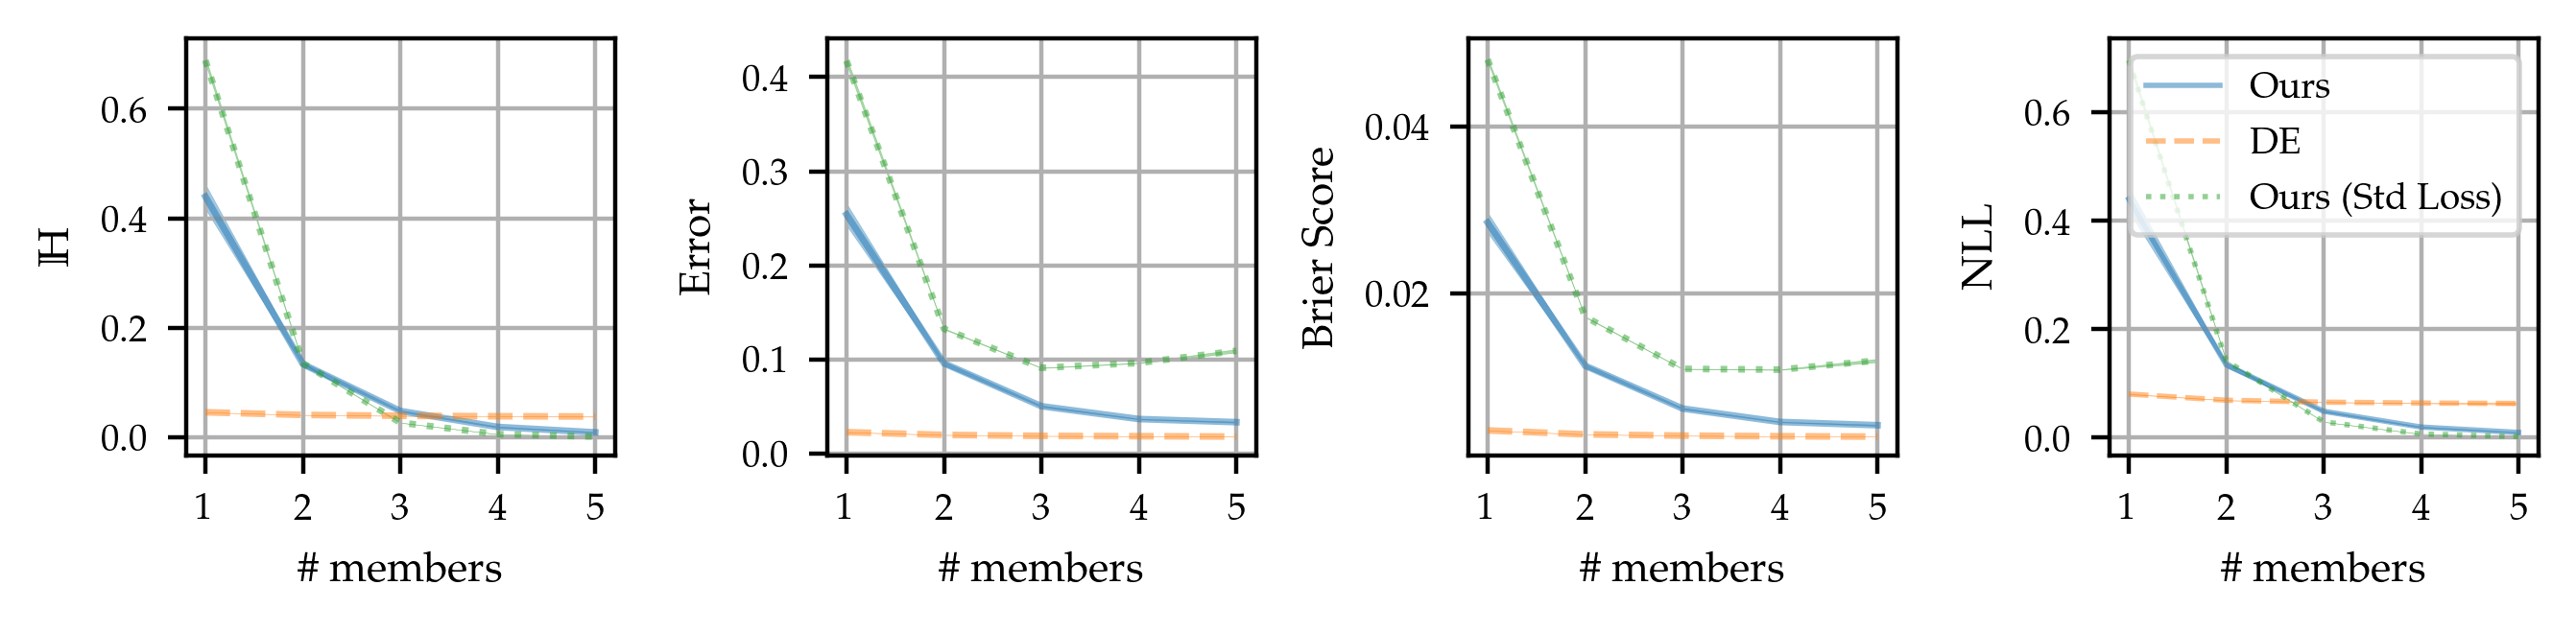

In [22]:
# matplotlib.style.use('default')
fig, axs = plt.subplots(1, 4, figsize=(text_width, text_width/4.), dpi=dpi, sharey=False, sharex=True, layout='tight')

models = ['Prod', 'Ens']
models += ['StdProd']

names = {
    'Prod': 'Ours',
    'Ens': 'DE',
    'StdProd': 'Ours (Std Loss)'
}

linestyles = {
    'Prod': '-',
    'Ens': '--',
    'StdProd': ':',
}

H_df = agg_df['H'].reset_index()
for i, model_name in enumerate(models):
    x = H_df[H_df.model_name == model_name]['n_members']
    y = H_df[H_df.model_name == model_name]['mean']
    y_err = H_df[H_df.model_name == model_name]['std_err']

    axs[0].plot(x, y, linestyles[model_name], c=f'C{i}', lw=1.25, alpha=0.5)
    axs[0].fill_between(x, y - y_err, y + y_err, color=f'C{i}', alpha=0.4, lw=0.1)

axs[0].grid(0.3)
axs[0].set_ylabel('$\mathbb{H}$')
axs[0].set_xlabel('$\#$ members')
axs[0].set_xticks(range(1, config.model.size + 1))

err_df = agg_df['brier'].reset_index()
for i, model_name in enumerate(models):
    x = err_df[err_df.model_name == model_name]['n_members']
    y = err_df[err_df.model_name == model_name]['mean']
    y_err = err_df[err_df.model_name == model_name]['std_err']

    axs[2].plot(x, y, linestyles[model_name], c=f'C{i}', lw=1.25, alpha=0.5, label=names[model_name])
    axs[2].fill_between(x, y - y_err, y + y_err, color=f'C{i}', alpha=0.4, lw=0.1)

axs[2].grid(0.3)
axs[2].set_ylabel('Brier Score')
axs[2].set_xlabel('$\#$ members')
axs[2].set_xticks(range(1, config.model.size + 1))

err_df = agg_df['err'].reset_index()
for i, model_name in enumerate(models):
    x = err_df[err_df.model_name == model_name]['n_members']
    y = err_df[err_df.model_name == model_name]['mean']
    y_err = err_df[err_df.model_name == model_name]['std_err']

    axs[1].plot(x, y, linestyles[model_name], c=f'C{i}', lw=1.25, alpha=0.5, label=names[model_name])
    axs[1].fill_between(x, y - y_err, y + y_err, color=f'C{i}', alpha=0.4, lw=0.1)

axs[1].grid(0.3)
axs[1].set_ylabel('Error')
axs[1].set_xlabel('$\#$ members')
axs[1].set_xticks(range(1, config.model.size + 1))

nll_df = agg_df[f'nll'].reset_index()
for i, model_name in enumerate(models):
    x = nll_df[nll_df.model_name == model_name]['n_members']
    y = nll_df[nll_df.model_name == model_name]['mean']
    y_err = nll_df[nll_df.model_name == model_name]['std_err']

    axs[3].plot(x, y, linestyles[model_name], c=f'C{i}', lw=1., alpha=0.5, label=names[model_name])
    axs[3].fill_between(x, y - y_err, y + y_err, color=f'C{i}', alpha=0.4, lw=0.1)

axs[3].grid(0.2)
axs[3].set_ylabel(f'NLL')
axs[3].set_xlabel('$\#$ members')
axs[3].set_xticks(range(1, config.model.size + 1))
axs[3].legend()

plt.savefig(f'mnist_entropy_err_nll_evolution.pdf', dpi=dpi, bbox_inches='tight')